# Non-Parametric Gaussian Kernel Density Estimation Fantasy Football Draft Assist Tool

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.distributions.mixture_rvs import mixture_rvs

# Part 1 - Data Import and Merging

First, we get the raw input data from:
https://fantasy.espn.com/football/players/projections?leagueFormatId=1
https://www.fantasysharks.com/apps/Projections/SeasonProjections.php?pos=ALL
https://www.fantasypros.com/nfl/rankings/consensus-cheatsheets.php?loggedin=&my-experts=ALL
https://fftoolbox.fulltimefantasy.com/football/rankings/index.php?noppr=true
https://fantasy.nfl.com/research/projections?position=O&sort=projectedPts&statCategory=projectedStats&statSeason=2020&statType=seasonProjectedStats#researchProjections=researchProjections%2C%2Fresearch%2Fprojections%253Fposition%253DO%2526statCategory%253DprojectedStats%2526statSeason%253D2020%2526statType%253DseasonProjectedStats%2526statWeek%253D1%2Creplace

and Yahoo!'s draft position list from:
https://football.fantasysports.yahoo.com/f1/826195/1/editprerank

These are all saved in the directory as .xlsx files

Next, we will compile and merge the data based on player names from the Yahoo! draft list (because that's what we will utilimately be calling on with the draft tool).

In [3]:
# load Yahoo! draft positions
df = pd.read_excel('Yahoo_2020_Draft_Positions.xlsx')
df['Name'] = df['Name'].str.strip() # strip the names so they can be directly compared to other lists

# load Fantasy Pros Projections
df1 = pd.read_excel('Fantasy_Pros_2020_proj.xlsx')

# construct temp data frame to merge relevant info
df_x = pd.DataFrame()
df_x['Name'] = df1['PLAYER'].str.strip()
df_x['fp_pts'] = df1['FAN PTS']

# merge df with temp df
df = pd.merge(df,
              df_x,
              on='Name',
              how ='outer')

# import NFL projections
df2 = pd.read_excel('NFL_2020_proj.xlsx')
df_x = pd.DataFrame()
df_x['Name'] = df2['PLAYER'].str.strip()
df_x['nfl_pts'] = df2['POINTS']

df = pd.merge(df,
              df_x,
              on='Name',
              how ='outer')

# import ESPN projections
df3 = pd.read_excel('ESPN_2020_proj.xlsx')

df_x = pd.DataFrame()
df_x['Name'] = df3['PLAYER'].str.strip()
df_x['espn_pts'] = df3['TOT']

df = pd.merge(df,
              df_x,
              on='Name',
              how ='outer')

# import Fantasy Shark projections
df4 = pd.read_excel('Fantasy_Shark_2020_proj.xlsx')

df_x = pd.DataFrame()
df_x['Name'] = df4['Name'].str.strip()
df_x['fs_pts'] = df4['Fantasy Points']

df = pd.merge(df,
              df_x,
              on='Name',
              how ='outer')

# import Sports Illustrated projections
df5 = pd.read_excel('Sports_Illustrated_2020_proj.xlsx')

df_x = pd.DataFrame()
df_x['Name'] = df5['PLAYER'].str.strip()
df_x['si_pts'] = df5['POINTS']

df = pd.merge(df,
              df_x,
              on='Name',
              how ='outer')

# drop the players not available in Yahoo!
df = df.dropna(subset=['Draft Position'])

# # check the dataframe head to verify import/merge worked
# df.head()

# Part 2 - Gaussian Kernel Density Estimation

Now for the non-parametric fun!

We will create a Gaussian kernel density estimation for each player using the projected points from each source (NFL, ESPN, Fantasy Sharks, etc.) for the kernels.

In [4]:
# create an empty column to store point projections for each player
df['pts'] = np.nan

# create an empty column to store the inverse cumulative density function data for each player's kde estimation
df['kde_icdf'] = [[] for _ in range(len(df))]

# # check the dataframe head to verify columns added
# df.head()

This block of code generates the non-parametric estimations for each player and stores: (i) the median value from the KDE as their projected points and (ii) the inverse CDF as an array in kde_icdf so we can generate the non-parametric confidence intervals for the draft tool.

Note - depending on your computer this may take several minutes to run, so go get a coffee or walk around the block!

In [299]:
for j in range(66,len(df)):
    # this block constructs an array for each player of the different fantasy point estimates. This array is used for the KDE.
    test_array = []
    test_array.append(df['fp_pts'][j])
    test_array.append(df['nfl_pts'][j])
    test_array.append(df['espn_pts'][j])
    test_array.append(df['fs_pts'][j])
    test_array.append(df['si_pts'][j])
    test_array = [x for x in test_array if str(x) != 'nan'] # clean the test_array for NaN values - which interfere with the analysis below
    if len(test_array) == 0:
        test_array = [0]
    
    # this sets up and runs the non-parametric estimation
    kde = sm.nonparametric.KDEUnivariate(test_array)
    kde.fit(kernel='gau', bw='silverman', fft=False) # Estimate the densities

    # This for loop processes to find the median projection
    ci_50 = 0 #initialize median value to zero
    for i in range(0, len(kde.cdf)):
        if kde.cdf[i] < 0.50:
            i+=1
        if kde.cdf[i] >= 0.50:
            ci_50 = kde.support[i]
            break

    # Add data to main dataframe
    df['pts'][j]=ci_50 # add median projection

    df['kde_icdf'][j]=kde.icdf # add icdf for whisker plot construction

# # check that data was generated/input correctly
# df.head()

# export dataset to .csv file so we don't have to run the code above again (it's time consuming!)
df.to_csv(r'C:\Users\Paul\Documents\Python Scripts\2020 FFL\2020_ffl_df.csv')

C:\Users\Paul\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Paul\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:353: RuntimeWarning: invalid value encountered in true_divide
  k = (X.T - grid[:, None])/bw  # uses broadcasting to make a gridsize x nobs
C:\Users\Paul\Anaconda3\lib\site-packages\statsmodels\sandbox\nonparametric\kernels.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  w = 1. / (h * n) * np.sum(self((xs-x)/h), axis=0)
C:\Users\Paul\An

,Draft Position,Name,POS,TEAM,fp_pts,nfl_pts,espn_pts,fs_pts,si_pts,pts,kde_icdf
0,1.0,Patrick Mahomes,QB,KC,292.04,348.33,336.1,407.0,424.9,361.924693,"[292.04, 292.04, 292.04, 292.04, 292.04, 292.0..."
1,2.0,Lamar Jackson,QB,Bal,421.68,366.23,338.5,425.0,391.0,393.524116,"[338.5, 338.5, 338.5, 338.5, 338.5, 338.5, 339..."
2,3.0,Dak Prescott,QB,Dal,348.78,304.36,301.5,373.0,386.8,346.575778,"[301.5, 301.5, 301.5, 301.5, 301.5, 301.5, 301..."
3,4.0,Russell Wilson,QB,Sea,333.60,309.06,293.9,352.0,354.6,332.662493,"[293.9, 293.9, 293.9, 293.9, 293.9, 293.9, 294..."
4,5.0,Kyler Murray,QB,Ari,297.28,291.92,299.5,301.0,381.3,300.834030,"[291.92, 291.92, 291.92, 291.92, 291.92, 291.9..."


Example for what we are doing with the KDE estimation. Set 'j' to be your favorite number, and we'll generate a Gaussian KDE probability density function for the player corresponding to that draft rank.

The various point estimates for that player (from ESPN, SI, ets.) are indicated by the red '+'s at the bottom of the graph. What KDE does is to center a normal gaussian distribution (with area = $\frac{1}{n}$ for n point estimates) over each of thes point estimates. Then, to generate the probabilty density function, we sum all of these "kernels" together - this summation is the orange line in the graph below.

Then, the following block of code generates a histogram from the KDE PDF showing the 1- and 2- standard deviation confidence intervals.

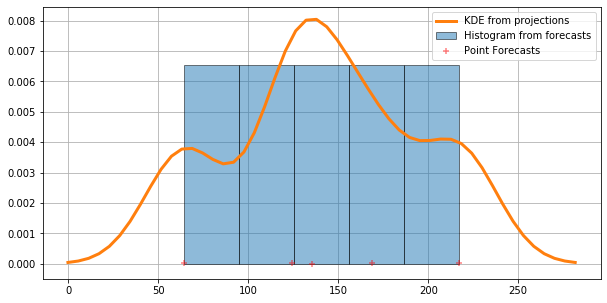

In [16]:
j = 125

# this block constructs an array for each player of the different fantasy point estimates. This array is used for the KDE.
test_array = []
test_array.append(df['fp_pts'][j])
test_array.append(df['nfl_pts'][j])
test_array.append(df['espn_pts'][j])
test_array.append(df['fs_pts'][j])
test_array.append(df['si_pts'][j])
test_array = [x for x in test_array if str(x) != 'nan'] # clean the test_array for NaN values - which interfere with the analysis below
if len(test_array) == 0:
    test_array = [0]
    
# this sets up and runs the non-parametric estimation
kde = sm.nonparametric.KDEUnivariate(test_array)
kde.fit(kernel='gau', bw='silverman', fft=False) # Estimate the densities


# Note: some plots for the kde visualizations that I'm turning off for the working loops
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

# Plot the histrogram
ax.hist(test_array, bins=5, density=True, label='Histogram from forecasts',
        zorder=5, edgecolor='k', alpha=0.5)
# Plot the KDE as fitted using the default arguments
ax.plot(kde.support, kde.density, lw=3, label='KDE from projections', zorder=10)
    
# Plot the samples
ax.scatter(test_array, np.abs(np.random.randn(len(test_array)))/100000,marker='+', color='red', zorder=20, label='Point Forecasts', alpha=0.5)
ax.legend(loc='best')
ax.grid(True, zorder=-5)

Example for confidence interval plots generated from the KDE PDF above.

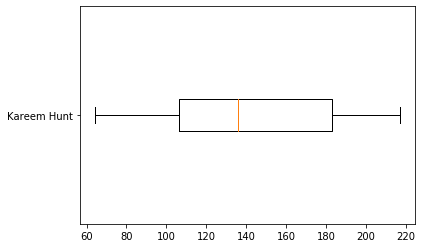

In [17]:
box_plot_data=kde.icdf
plt.boxplot(box_plot_data, vert=False, labels=[df['Name'][j]])
plt.show()